# Objective

Conduct a Specific Gage Analysis using both the rating curve method and the direct method.

# Mississippi River at Thebes

Read data from Thebes gage using tsv file from https://waterservices.usgs.gov/rest/dv

In [1]:
#!head -n 40 thebes.tsv

In [2]:
import pandas as pd
nyears=30
start_year = 1990
f = pd.read_table("thebes.tsv",header=32).dropna(axis=1,how='all').drop([0])#.dropna(axis=0,how='any')
f.datetime=pd.to_datetime(f.datetime)
f = f.rename(columns={'76125_00060_00003': 'discharge',
                      '76124_00065_30800': 'stage', 
                      '76126_80154_00003': 'sediment', 
                      '76127_80155_00003': 'sediment_load'})
f.head()

,agency_cd,site_no,datetime,discharge,76125_00060_00003_cd,stage,76124_00065_30800_cd,sediment,76126_80154_00003_cd,sediment_load,76127_80155_00003_cd
1,USGS,07022000,1990-01-01,54500,A,1.98,A:e,67.0,A,9850,A
2,USGS,07022000,1990-01-02,54600,A,2.16,A:e,72.7,A,10700,A
3,USGS,07022000,1990-01-03,54600,A,2.10,A:e,59.1,A,8710,A
4,USGS,07022000,1990-01-04,58600,A,2.94,A:e,63.8,A,10100,A
5,USGS,07022000,1990-01-05,64800,A,4.72,A:e,88.7,A,15500,A


In [3]:
f.tail()

,agency_cd,site_no,datetime,discharge,76125_00060_00003_cd,stage,76124_00065_30800_cd,sediment,76126_80154_00003_cd,sediment_load,76127_80155_00003_cd
10942,USGS,07022000,2019-12-27,228000,P,20.56,P,NaN,NaN,NaN,NaN
10943,USGS,07022000,2019-12-28,223000,P,20.02,P,NaN,NaN,NaN,NaN
10944,USGS,07022000,2019-12-29,229000,P,19.85,P,NaN,NaN,NaN,NaN
10945,USGS,07022000,2019-12-30,262000,P,21.91,P,NaN,NaN,NaN,NaN
10946,USGS,07022000,2019-12-31,293000,P,23.70,P,NaN,NaN,NaN,NaN


Check the record

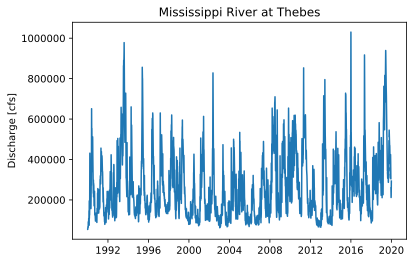

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
discharge = np.array(f.discharge,'d')
plt.plot(f.datetime, discharge)
plt.ylabel('Discharge [cfs]')
plt.title('Mississippi River at Thebes');

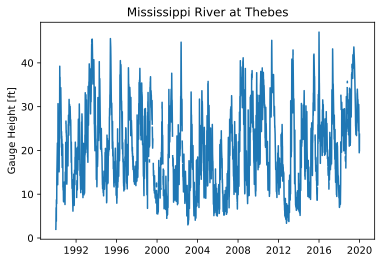

In [5]:
stage = np.array(f.stage,'d')
plt.plot(f.datetime,stage)
plt.ylabel('Gauge Height [ft]')
plt.title('Mississippi River at Thebes');

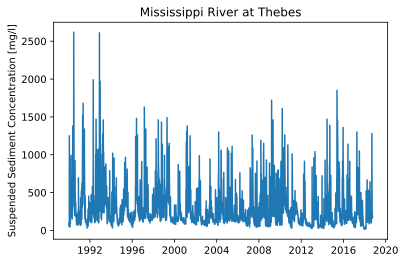

In [6]:
sediment = np.array(f.sediment,'d')
plt.plot(f.datetime,sediment)
plt.ylabel('Suspended Sediment Concentration [mg/l]')
plt.title('Mississippi River at Thebes');

# Check each year in the record and generate rating curve

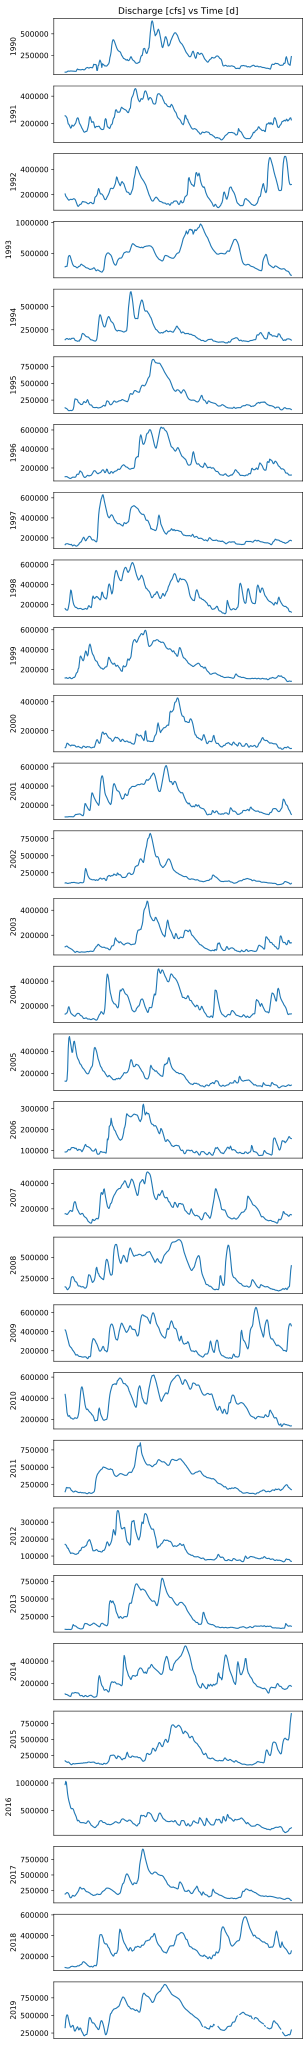

In [7]:
import datetime as dt
fig, ax = plt.subplots(nyears)
fig.set_figheight(50)
ax[0].set_title('Discharge [cfs] vs Time [d]')
for i in range(nyears):
    index = np.logical_and(f.datetime >= dt.datetime(start_year+i,1,1,0,0,0),
                           f.datetime < dt.datetime(start_year+i+1,1,1,0,0,0))
    ax[i].plot(f.datetime[index], discharge[index])
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_ylabel(start_year+i)

## *Note: some discharge values missing in 2019*

In [8]:
# Build rating curves. Quadratic provided a good fit.

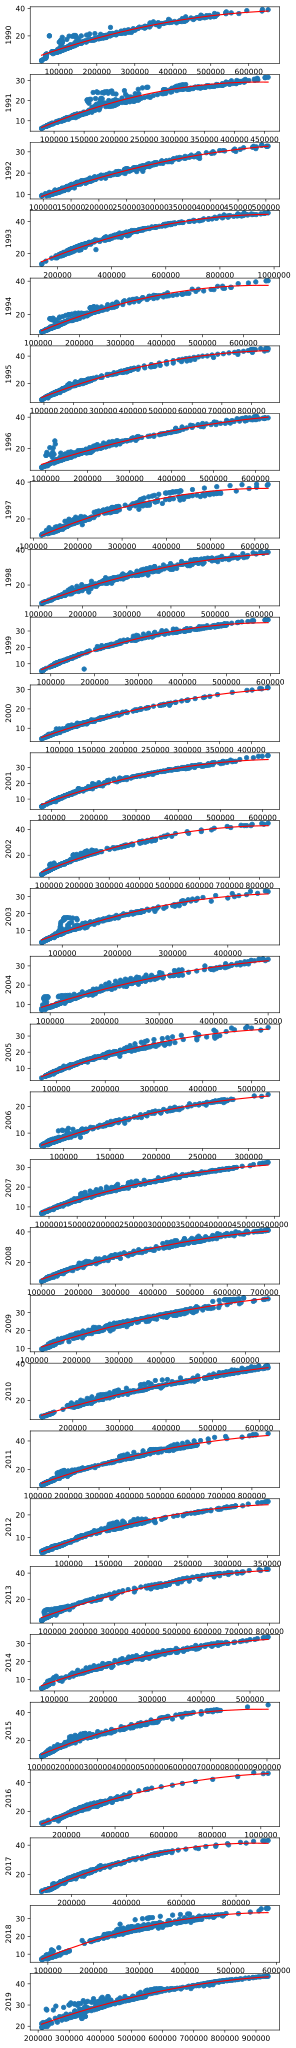

In [9]:
fig, ax = plt.subplots(nyears)
fig.set_figheight(50)
c=[]
curves={100000: [],
        200000: [],
        300000: [],
        400000: [],
        500000: [],
        600000: [],
        700000: [],
        800000: [],
        900000: []}
years = []
for i in range(nyears):
    index = np.logical_and(f.datetime >= dt.datetime(start_year+i,1,1,0,0,0),
                           f.datetime < dt.datetime(start_year+i+1,1,1,0,0,0))
    isort = np.argsort(discharge[index])
    dyear = (discharge[index])[isort]
    syear = (stage[index])[isort]
    rindex = np.logical_and(np.isfinite(dyear),np.isfinite(syear))
    dyear = dyear[rindex]
    syear = syear[rindex]
    ax[i].scatter(dyear,syear)
    c2 = np.polyfit(dyear, syear, deg=2)
    ax[i].plot(dyear,
               c2[2] + c2[1]*dyear + c2[0]*dyear**2,'r')
    ax[i].set_ylabel(start_year+i)
    years.append(start_year+i)
    c.append(c2)
    for D in curves.keys():
        if D < dyear.max():
            curves[D].append(c2[2] + c2[1]*D + c2[0]*D**2)
        else:
            curves[D].append(np.nan)

# Plot Stage Record for the Chosen Discharges

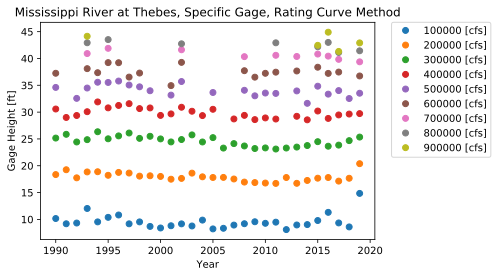

In [10]:
for i in range(9):
    plt.plot(years,curves[(i+1)*100000],'o')
plt.ylabel("Gage Height [ft]")
plt.xlabel("Year")
plt.legend(["{0} [cfs]".format(k) for k in curves.keys()],
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Mississippi River at Thebes, Specific Gage, Rating Curve Method");

# Direct Step Method

In [11]:
f.discharge = pd.to_numeric(f.discharge)
f.sort_values(by="discharge",axis=0,inplace=True)

Put the stages in a bid if the discharge is near the center of a bin. The way I bin them using logical selection of indices, it's not actually necessary to sort the discharges, but I'll leave the sort above in.

In [12]:
bin_factor = 0.1
bins={}
for i in range(9):
    bin_center = (i+1)*100000.0
    bin_radius = bin_factor*bin_center
    index = np.logical_and(f.discharge > bin_center - bin_radius ,
                           f.discharge < bin_center + bin_radius)
    bins[i]=(np.array(f.datetime[index],np.datetime64),np.array(f.stage[index],'d'))

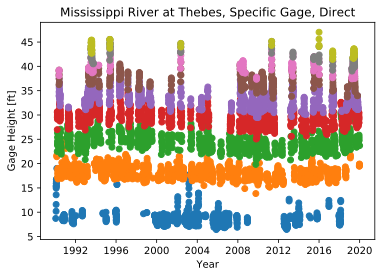

In [13]:
for i in range(9):
    plt.plot(bins[i][0],bins[i][1],'o')
plt.ylabel('Gage Height [ft]')
plt.xlabel('Year')
plt.title("Mississippi River at Thebes, Specific Gage, Direct");